<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agentchat_groupchat_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Group Chat with Coder Visualization and Personalization Critic
 

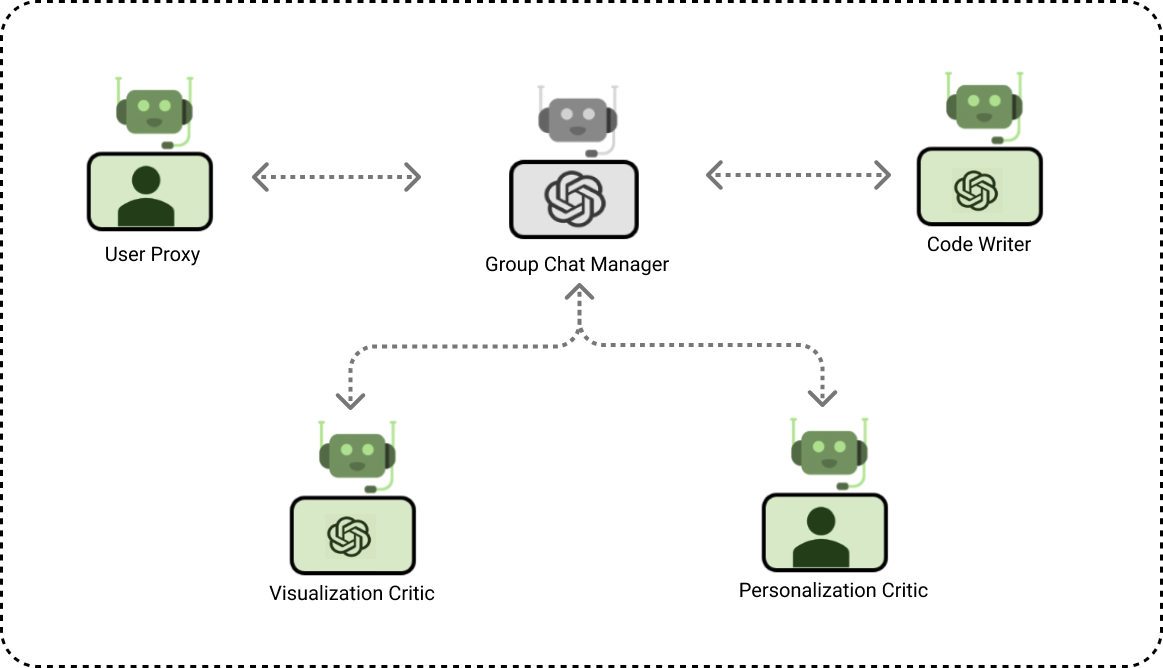

In [1]:
from IPython.display import Image
Image(filename='images/agent.png') 

In [1]:
%%capture --no-stderr
# %pip install pyautogen

import autogen

config_list_gpt4 = autogen.config_list_from_json(
    "../../OAI_CONFIG_LIST",
     
) 

## Setup User Profile 

In [ ]:
user_profile = """
Adam Fourney is a researcher at Microsoft Research, Redmond. Adam did his PhD at the University of Waterloo, studying problems at the intersection of HCI and information retrieval. His dissertation studied how people use web search to support their broader information work, such as using complex software, or programming. Since joining Microsoft, Adam has adapted his research to study similar questions, but about the use of large generative language models like GPT.
In research, and at home, Adam is a builder: he builds and tests prototypes, is proficient in Python, C, SQL, web development, Linux, and other tools of the trade. 

When Adam creates visualizations or writes visualization code, 
all axis labels MUST HAVE UNITS and 
the title of each chart MUST be BOLD FONT. 

His prototypes are not limited to software and extend to physical prototyping with Arduinos, Raspberry Pis, etc. He often applies these skills to his other hobbies including photography, and outdoor activities such as biking, hiking and camping. As an example, building rigs for timelapse, stereo, and arial kite photography.

When interacting with Adam, know that he prefers direct concise communication. In writing, this translates to using an active voice, and limiting run-on sentences. Important points should be called out visually such as via bullet points of other emphasis. In programming, this means that code should be well-documented, with appropriate in-line comments. Code should be written for readability, avoiding clever syntax tricks, deeply nested list comprehensions, etc. Since Adam frequently switches between machines and operating systems,  Adam values portability, preferring built-in libraries over complex external dependencies.

"""

In [3]:
# Personalization critic
personalization_sys_message =f"""
You will be receiving messages from an assistant who was contracted by the individual employer with the the follow biography:

<biography>
{user_profile}
</biography>

Your job is to provide a final quality-check. YOU MUST ENSURE THAT THE ASSISTANT'S OUTPUT ADHERES TO THE RELEVANT  INTERESTS AND PREFERENCES IN THE BIOGRAPHY ABOVE. If you find that the assistants' responses are deficient with respect to this biography, you will provide specific critical feedback to help the assistant improve their output. 

TO DO THIS, YOU MUST FIRST OUTLINE ASPECTS OF THE BIO THAT ARE RELEVANT TO THE ASSISTANT'S OUTPUT AND THEN PROVIDE SPECIFIC FEEDBACK ON HOW THE ASSISTANT'S OUTPUT CAN BE IMPROVED.


Remember that you are the expert on what the employer wants BASED ON THE BIO provided. The contracted assistant has not previously worked for the  employer, and does not know them. YOU MUST THINK STEP BY STEP, AND CHECK IF THE ASSISTANT'S OUTPUT MEETS THE RELEVANT ASPECTS OF THE BIO. You may need to provide the assistant with relevant aspects of the  biographic information for them to complete the task. Once everything looks ok and there is no feedback necessary, simply list out all the ways in which the output is compliant and then reply with "all looks good, thank you, please proceed!".
"""
# print(reviewer_sys_message)

visualization_critic_sys_message = """Critic. You are a helpful assistant highly skilled in evaluating the quality of a given visualization code by providing a score from 1 (bad) - 10 (good) while providing clear rationale. YOU MUST CONSIDER VISUALIZATION BEST PRACTICES for each evaluation. Specifically, you can carefully evaluate the code across the following dimensions
- bugs (bugs):  are there bugs, logic errors, syntax error or typos? Are there any reasons why the code may fail to compile? How should it be fixed? If ANY bug exists, the bug score MUST be less than 5.
- Data transformation (transformation): Is the data transformed appropriately for the visualization type? E.g., is the dataset appropriated filtered, aggregated, or grouped  if needed? If a date field is used, is the date field first converted to a date object etc?
- Goal compliance (compliance): how well the code meets the specified visualization goals?
- Visualization type (type): CONSIDERING BEST PRACTICES, is the visualization type appropriate for the data and intent? Is there a visualization type that would be more effective in conveying insights? If a different visualization type is more appropriate, the score MUST BE LESS THAN 5.
- Data encoding (encoding): Is the data encoded appropriately for the visualization type?
- aesthetics (aesthetics): Are the aesthetics of the visualization appropriate for the visualization type and the data?

YOU MUST PROVIDE A SCORE for each of the above dimensions.
{bugs: 0, transformation: 0, compliance: 0, type: 0, encoding: 0, aesthetics: 0}
Do not suggest code. 
Finally, based on the critique above, suggest a concrete list of actions that the coder should take to improve the code.
"""

## Construct Multi-Agent Setup 

In [4]:
llm_config = {"config_list": config_list_gpt4, "seed": 42, "temperature":0.1}
user_proxy_agent = autogen.UserProxyAgent(
   name="user_proxy_assistant",
   system_message="A human admin.",
   code_execution_config={"last_n_messages": 3, "work_dir": "groupchat"},
   human_input_mode="NEVER",
)
code_writer_agent = autogen.AssistantAgent(
    name="code_writer_assistant",  # the default assistant agent is capable of solving problems with code
    llm_config=llm_config,
)
visualization_critic_agent = autogen.AssistantAgent(
    name="visualization_critic_assistant",
    system_message=visualization_critic_sys_message,
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user"
personalization_critic_agent = autogen.AssistantAgent(
    "personlization_critic_assistant",
    llm_config=llm_config,
    system_message=personalization_sys_message,
    max_consecutive_auto_reply=20,
)

groupchat = autogen.GroupChat(
      agents=[user_proxy_agent, code_writer_agent, visualization_critic_agent, personalization_critic_agent], messages=[], max_round=20)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config, name="everyone")


## Start Chat 

 

In [5]:
user_request = """
download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and 
show me a plot that tells me about the amount of each weather. Save the plot as an image to disc. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.
"""
user_proxy_agent.initiate_chat(manager, message=user_request)


user_proxy_assistant (to everyone):


download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and show me a plot that tells me about the amount of each weather . Save the plot as an image to disc. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.


--------------------------------------------------------------------------------
code_writer_assistant (to everyone):

Sure, we can use the pandas library to download and read the data, and matplotlib to visualize it. Here is the Python code to do that:

```python
# filename: weather_plot.py

import pandas as pd
import matplotlib.pyplot as plt

# Download and read the data
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)

# Print the fields in the dataset
print("Fields in the dataset: ", data.columns.tolist())

# Count the amount of each weather
weather_counts = data['weather'].valu

## Before Critic  

Fields in the dataset:  ['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather']


Text(0.5, 1.0, 'Amount of Each Weather in Seattle')

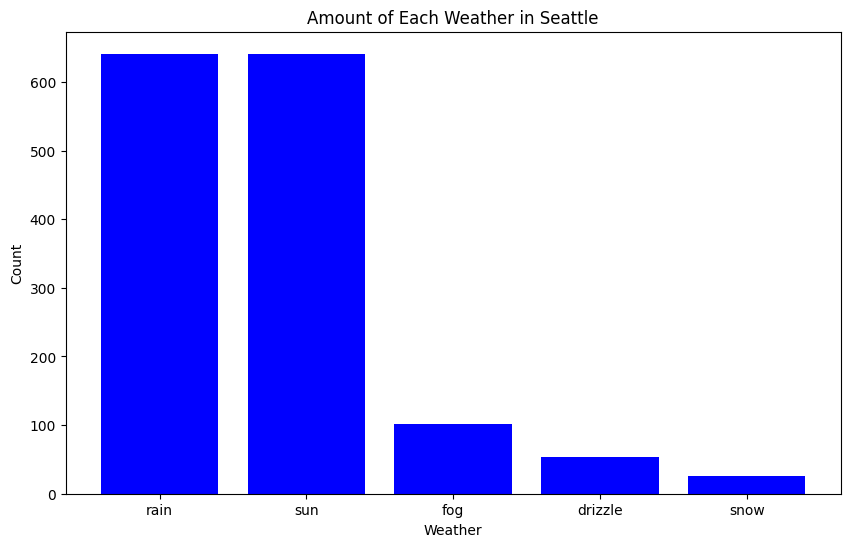

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Download and read the data
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)

# Print the fields in the dataset
print("Fields in the dataset: ", data.columns.tolist())

# Count the amount of each weather
weather_counts = data['weather'].value_counts()

# Plot the data
plt.figure(figsize=(10,6))
plt.bar(weather_counts.index, weather_counts.values, color='blue')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Amount of Each Weather in Seattle')

## After Visualization and Personalization Critic 

- The visualization critic asks for distinct colors per weather type 
- the personalization critic makes the title bold adds units to the appropriate axes.

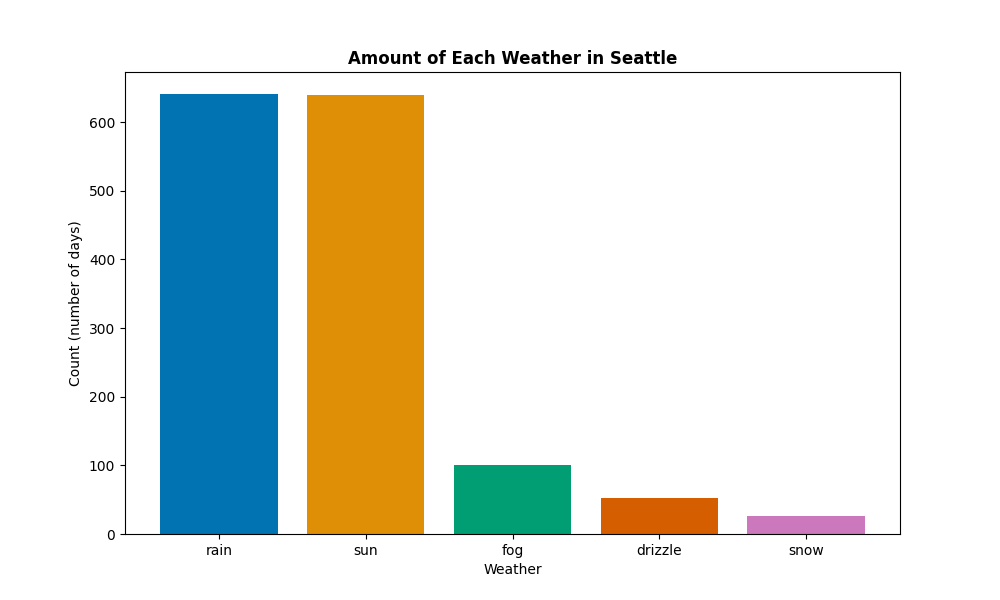

In [9]:
from IPython.display import Image
Image(filename='images/weather_plot_improved.png') 